## Assignment 11

# Extended Kalman filter for navigation and tracking

**Starodumova P., Antonov A., Babaev N., Krivova V. | Skoltech EDP course by Tatiana Podladchikova, 2020**

**The objective of this laboratory work is to develop Extended Kalmanfilter for tracking a moving object when measurements and motion model are in different coordinate systems. This will bring about  a  deeper  understanding  of  main  difficulties  of  practical  Kalman  filter  implementation  for nonlinear models.**

In [21]:
# importing libraries

import numpy as np
import matplotlib.pyplot as plt

In [22]:
# plot graphs

def showPlease(arr,legend = [],xlabel ="x",ylabel="y",title="title"):
    params = {'legend.fontsize': 20,
          'legend.handlelength': 2}
    plt.rcParams.update(params)
    fig, ax = plt.subplots()
    max_len = 0
    for i in arr:
        if(len(i) > max_len):
            max_len = len(i)
    for i in arr:
        if(len(i) == max_len):
            plt.plot(i)
        else:
            plt.plot([j for j in range(max_len - len(i),max_len)],i)
    fig.set_figwidth(15)
    fig.set_figheight(7)
    plt.grid()
    plt.xlabel(xlabel, fontsize = 16)
    plt.ylabel(ylabel, fontsize = 16)
    plt.legend(legend)
    plt.title(title, fontsize = 16);
    plt.show()

**In this assignment we work not with deterministic model of process, but in conditions of present noise – more specifically with object motion disturbed by normally distributed random acceleration.**

**Firsty we define a true trajectory, introducing initial conditions.**

In [23]:
def true_traj(n, T, x_0, y_0, v_x_0, v_y_0, σ_a):
    x = np.array([x_0])
    y = np.array([y_0])
    v_x = np.array([v_x_0])
    v_y = np.array([v_y_0])
    a_x = np.random.normal(0, σ_a, n-1)
    a_y = np.random.normal(0, σ_a, n-1)
    for i in range(n-1):
        
        x = np.append(x, (x[i] + v_x[i] * T + 
                          a_x[i] * T ** 2 / 2))
        v_x = np.append(v_x, (v_x[i] + a_x[i] * T))
        
        y = np.append(y, (y[i] + v_y[i] * T + 
                          a_y[i] * T ** 2 / 2))
        v_y = np.append(v_y, (v_y[i] + a_y[i] * T))
    
    return np.array([x, v_x, y, v_y])

In [24]:
# size of trajectory
n = 500

# interval between measurements
T = 1 

# initial coordinates 
x_0 = 1000
y_0 = 1000

# initial components of velocity
v_x_0 = 10
v_y_0 = 10

# variance of noise for acceleration's projections on both axes
σ_a = 0.3

# introducing the trajectory X
X = true_traj(n, T, x_0, y_0, v_x_0, v_y_0, σ_a)

**Then we obtain true values of range D and azimuth β – polar coordinates from Cartesian ones using conversion formulas.**

In [25]:
def polar(x, y):
    xx = x.copy()
    yy = y.copy()
    D = (xx ** 2 + yy ** 2) ** 0.5
    β = np.arctan(xx / yy)
    return D, β

In [26]:
D, β = polar(X[0], X[2])

**We also introduce the measurements of range and azimuth. In this assignment we do not perform any transformation of measurements (between polar and Cartesian coordinate systems) as the task is to work directly with nonlinear measurement equation.**

In [27]:
def polar_meas(n, D, β, σ_D, σ_β):
    σ_DD = np.random.normal(0, σ_D, n)
    σ_ββ = np.random.normal(0, σ_β, n)
    return (D + σ_DD), (β + σ_ββ)

In [28]:
σ_D = 50
σ_β = 0.004
D_meas, β_meas = polar_meas(n, D, β, σ_D, σ_β)

**We have a linear state equation, to execute the algorithm of extended Kalman filter we define a filtered estimate of state vector and filtration error covariance matrix.**

In [29]:
X_0_0 = np.array([
                 [D_meas[0] * np.sin(β_meas[0])],
                 [0],
                 [D_meas[0] * np.cos(β_meas[0])],
                 [0]
                 ])
P_0_0 = np.array([
                 [10 ** 10, 0, 0, 0],
                 [0, 10 ** 10, 0, 0],
                 [0, 0, 10 ** 10, 0],
                 [0, 0, 0, 10 ** 10]
                 ])

 **Building the transition matrix ϕ:**

In [30]:
ϕ = np.array([
             [1, T, 0, 0],
             [0, 1, 0, 0],
             [0, 0, 1, T],
             [0, 0, 0, 1]
             ])

**Calculating the state noise covariance matrix Q using the input matrix G (which shows how random noise affects the components of state vector):**

In [31]:
G = np.array([
             [T ** 2 / 2, 0],
             [T, 0],
             [0, T ** 2 / 2],
             [0, T]
             ])
Q = G @ G.T * σ_a ** 2

**Now we create measurement noise covariance matrix 𝑅:**

In [32]:
R = np.array([
             [σ_D ** 2, 0],
             [0, σ_β ** 2]
             ])

**To execute the reccurrent filtering algorithm correctly we will need to linearize our measurements equation. So let's add function that calculates the derivative of extrapolated esimate with respect to state vector.**

In [33]:
def linearize(x, y):
    return np.array([
                    [x / (x ** 2 + y ** 2) ** 0.5, 0, y / (x ** 2 + y ** 2), 0],
                    [y / (x ** 2 + y ** 2), 0, -x / (x ** 2 + y ** 2), 0]
                    ]).astype('float64')

**The algorithm is about predicting the state vector using previous measurements and subsequent filtration. In the extended Kalman we will use mentioned deivative instead of transition matrix. Again producing Taylor series helps us with it.**

**Aiming to estimate state vector 𝑋𝑖 at every extrapolation and filtration step we calculate the values of range and azimuth. Adding a number of fuctions to develop the filter:**

In [34]:
def kalman(X_0_0, P_0_0, ϕ, R, Q, D_meas, β_meas, n):
    X = [X_0_0]
    D_ex = [] 
    β_ex = []
    P = [P_0_0]
    K = [] 
    D = np.array([(X_0_0[0] ** 2 + X_0_0[2] ** 2) ** 0.5])
    β = np.array([np.arctan(X_0_0[0] / X_0_0[2])])
    X_i_i = X_0_0
    P_i_i = P_0_0
    for i in range(n-1):
        X_i1_i = ϕ @ X_i_i
        D_ex.append((X_i1_i[0] ** 2 + X_i1_i[2] ** 2) ** 0.5)
        β_ex.append(np.arctan(X_i1_i[0] / X_i1_i[2]))
        P_i1_i = ϕ @ P_i_i @ ϕ.T + Q
        
        h = np.array([
                     (X_i1_i[0] ** 2 + X_i1_i[2] ** 2) ** 0.5,
                     np.arctan(X_i1_i[0] / X_i1_i[2])
                     ])
        Z = np.array([
                      [D_meas[i+1]],
                      [β_meas[i+1]]
                     ])
        dh_dX = linearize(X_i1_i[0], X_i1_i[2])
        K = P_i1_i @ dh_dX.T @ np.linalg.inv(dh_dX @ P_i1_i @ dh_dX.T + R)
        
        X_i_i = X_i1_i + K @ (Z - h)
        X.append(X_i_i)
        D = np.append(D, (X_i_i[0] ** 2 + X_i_i[2] ** 2) ** 0.5)
        β = np.append(β, np.arctan(X_i_i[0] / X_i_i[2]))
        
        P_i_i = (np.eye(4) - K @ dh_dX) @ P_i1_i
        P.append(P_i_i)
    
    return np.array(X), D, β, np.array(D_ex), np.array(β_ex), np.array(P)

In [35]:
X_kal, D_kal, β_kal, D_ex_kal, β_ex_kal, P_kal = kalman(X_0_0, P_0_0, ϕ, R, Q, D_meas, β_meas, n)

**Let's run the filtering process:**

In [67]:
# one iteration
def create_process():
    n = 500
    T = 1
    x_0 = 1000
    y_0 = 1000
    v_x_0 = 10
    v_y_0 = 10
    σ_a = 0.3
    X = true_traj(n, T, x_0, y_0, v_x_0, v_y_0, σ_a)
    
    D, β = polar(X[0], X[2])
    
    σ_D = 50
    σ_β = 0.004
    D_meas, β_meas = polar_meas(n, D, β, σ_D, σ_β)
    return D, β, D_meas, β_meas

In [68]:
# number of runs
def manykalman(num):
    mist_D = []
    mist_D_ex = []
    mist_D_meas =[]
    mist_β = []
    mist_β_ex = []
    mist_β_meas = []
    for i in range(num):
        D, β, D_meas, β_meas = create_process()
        X_kal, D_kal, β_kal, D_ex_kal, β_ex_kal, P_kal = kalman(X_0_0, P_0_0, ϕ, R, Q, D_meas, β_meas, n)
        mist_D.append((D - D_kal) ** 2)
        mist_D_ex.append((D[1:] - D_ex_kal.flatten()) ** 2)
        mist_D_meas.append((D - D_meas) ** 2)
        
        mist_β.append((β - β_kal) ** 2)
        mist_β_ex.append((β[1:] - β_ex_kal.flatten()) ** 2)
        mist_β_meas.append((β - β_meas) ** 2)
        
    fin_mist_D = (np.array(mist_D).sum(0) / 499) ** 0.5
    fin_mist_D_ex = (np.array(mist_D_ex).sum(0) / 498) ** 0.5
    fin_mist_D_meas = (np.array(mist_D_meas).sum(0) / 498) ** 0.5
    
    fin_mist_β = (np.array(mist_β).sum(0) / 499) ** 0.5
    fin_mist_β_ex = (np.array(mist_β_ex).sum(0) / 498) ** 0.5
    fin_mist_β_meas = (np.array(mist_β_meas).sum(0) / 498) ** 0.5


        
    return fin_mist_D, fin_mist_D_ex, fin_mist_β, fin_mist_β_ex, fin_mist_D_meas, fin_mist_β_meas

In [56]:
fin_mist_D, fin_mist_D_ex, fin_mist_β, fin_mist_β_ex, fin_mist_D_meas, fin_mist_β_meas = manykalman(500)

**Let's look at true estimation errors of extrapolation and filtration for range D and azimuth β:**

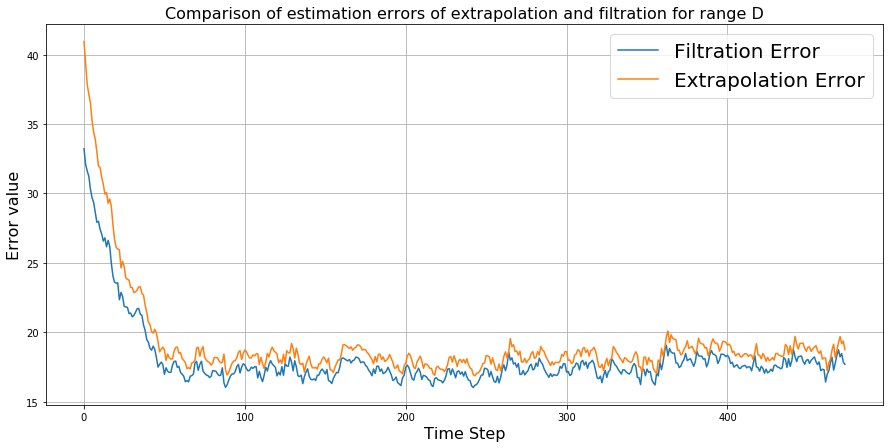

In [65]:
showPlease([fin_mist_D[26:], fin_mist_D_ex[25:]],
           ['Filtration Error', 'Extrapolation Error'], 'Time Step','Error value','Comparison of estimation errors of extrapolation and filtration for range D')

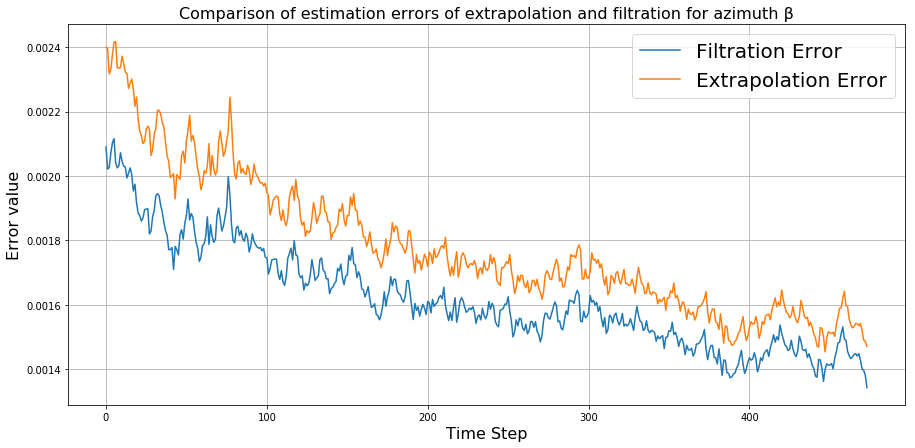

In [66]:
showPlease([fin_mist_β[26:], fin_mist_β_ex[25:]], ['Filtration Error', 'Extrapolation Error'],'Time Step','Error value','Comparison of estimation errors of extrapolation and filtration for azimuth β')

We can observe that filtering extrapolation error is greater than filtration one, but both decrease while Kalman filter converges.

**Now let's compare estimation results with measurement errors of D and 𝛽:**

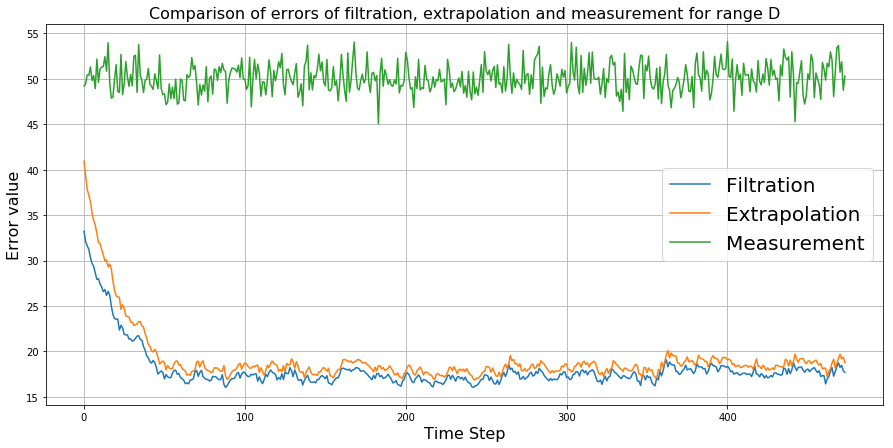

In [63]:
showPlease([fin_mist_D[26:], fin_mist_D_ex[25:], fin_mist_D_meas[26:]],
           ['Filtration', 'Extrapolation', 'Measurement'],'Time Step','Error value','Comparison of errors of filtration, extrapolation and measurement for range D')

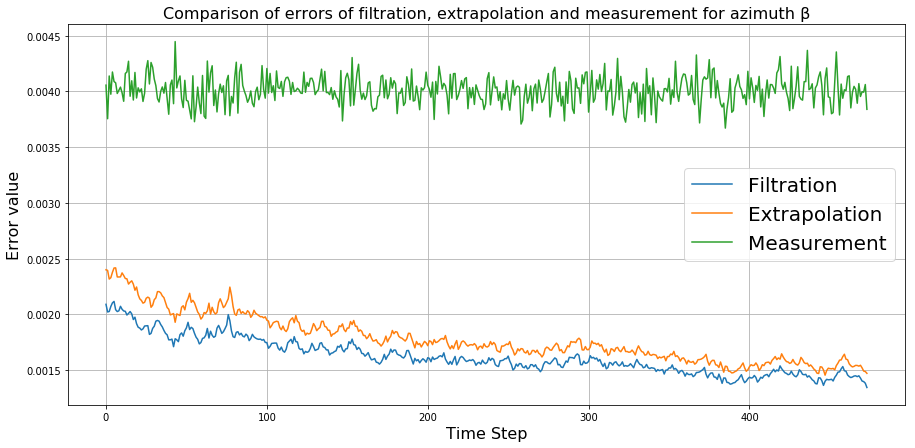

In [64]:
showPlease([fin_mist_β[26:], fin_mist_β_ex[25:], fin_mist_β_meas[26:]],
           ['Filtration', 'Extrapolation', 'Measurement'],'Time Step','Error value','Comparison of errors of filtration, extrapolation and measurement for azimuth β')